In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
import math
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import shelve

from tqdm.auto import trange

from rknot import Sim
from rknot.dots.matrix import ML, MLNB
from rknot.helpers import md, contacts_of_init_inf, find_n_sec, get_results
from rknot.nb.funcs import find_all_contacts
from rknot.dots.fhutch import tmr

UPDATEDB = False

### Sizing ###

Appropriate sizing of a simulation environment is more art than science but we can use several tools in the **RKnot** package and the scientific literature to approximate appropriate attributes and initial conditions.

To summarize, our approach to sizing is as follows:

1. Contact rate should follow a gamma distribution as defined in the [Hutch model](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf).
2. Aim for mean and variance of contact rate as outlined in the Hutch model.
3. $R_0$ distribution should replicate the [Endo distribution](https://wellcomeopenresearch.org/articles/5-67#ref-12).
4. Favor more Events over greater density.

Detailed and justified further below.

Thus, in order to appropriately size, we must be able to measure:

1. the contact rate of an environment during the initial infection duration
2. the $R_0$ of an environment

#### Contact Rates ####

The contact rate of indiviudals and the broader population is fundamentally important to the $R_0$ of a virus. All else equal, an infected individual will likely cause more secondary infections if they have more contacts.

Equally important are both the timing and distribution of contacts around the mean. The Hutch model uses a gamma distribution to generate contact regimes using mean and variance parameters to shape:

$$
c_t\;\approx\;\Gamma(\frac{\mu}{\rho}, {\rho})
$$

**RKnot** tends to most reliabily replicate the SIR model in the [Equal Mover scenario](sir.ipynb#1.-Equal). 

We ran 1,000 iterations of that scenario to investigate the contact distribution. 

In [96]:
file = 'tests/data/transmit'
db = shelve.open(file, writeback=True)

equal_scen = db[f'SIR equal 10000n dens1']['2020-11-15']
db.close()

contacts = equal_scen['contacts']
R0 = equal_scen['R0']
meanstr = round(contacts.mean(), 4)
varstr = round(contacts.var(), 4)

msg = f'These iterations resulted in a mean contact rate of {meanstr} '
msg += f'and a variance of {varstr}. '

msg += 'We can see the distribution of the contacts per day in the histogram below.'
md(msg)

These iterations resulted in a mean contact rate of 0.9973 and a variance of 0.9731. We can see the distribution of the contacts per day in the histogram below.

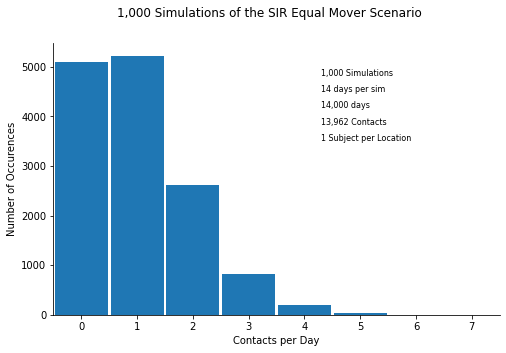

In [97]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,5))
counts, bins, _ = ax1.hist(contacts.ravel(), bins=np.arange(contacts.max() + 2), rwidth=.95)

xmax = contacts.max() + 1
ax1.set_xlim(0, xmax)
ax1.set_xticks([i+.5 for i in range(xmax)])
ax1.set_xticklabels([str(i) for i in range(xmax)])
ax1.set_xlabel('Contacts per Day')
ax1.set_ylabel('Number of Occurences')

ax1.text(0.6, 0.88, f'{contacts.shape[0]:,} Simulations', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.82, f'{contacts.shape[1]:.0f} days per sim', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.76, f'{contacts.shape[0] * contacts.shape[1]:,} days', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.70, f'{contacts.sum():,} Contacts', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.64, f'1 Subject per Location', size=8, transform=ax1.transAxes)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.suptitle(f'{contacts.shape[0]:,} Simulations of the SIR Equal Mover Scenario')

plt.show()

The distribution reveals that on *about a third of all days* the infected subject had no contacts at all. And on a third of all days the infected had a single contact. And remaining days had more, including a single day where an infected had 8 contacts.

And it just so happens this distribution fits the Hutch gamma quite well, as per below:

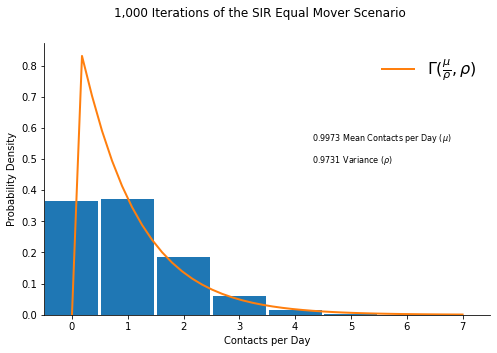

In [98]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,5))

counts, bins, _ = ax1.hist(contacts.ravel(), bins=np.arange(contacts.max() + 2), rwidth=.95, density=True)

a = contacts.mean() / contacts.var()
scale = contacts.var()
rv = gamma(a, scale=scale)
x = np.linspace(0,contacts.max(),40)
ax1.plot(x+0.5, rv.pdf(x), lw=2, label=r'$\Gamma(\frac{\mu}{\rho}, \rho)$')

ax1.set_xlim(0, xmax)
ax1.set_xticks([i+.5 for i in range(xmax)])
ax1.set_xticklabels([str(i) for i in range(xmax)])
ax1.set_xlabel('Contacts per Day')
ax1.set_ylabel('Probability Density')
ax1.text(0.6, 0.64, f'{meanstr:,} Mean Contacts per Day ' + r'($\mu$)', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.56, f'{varstr:,} Variance ' + r'($\rho$)', size=8, transform=ax1.transAxes)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.legend(loc='best', frameon=False, prop={'size': 16})

plt.suptitle(f'{contacts.shape[0]:,} Iterations of the SIR Equal Mover Scenario')
plt.show()

With 0 contacts per day accounting for such a high proportion of days, it is likely that even in the SIR model many infected subjects do not cause *any* secondary infections.

Below we show the number of secondary infections caused be each single infected subject. 

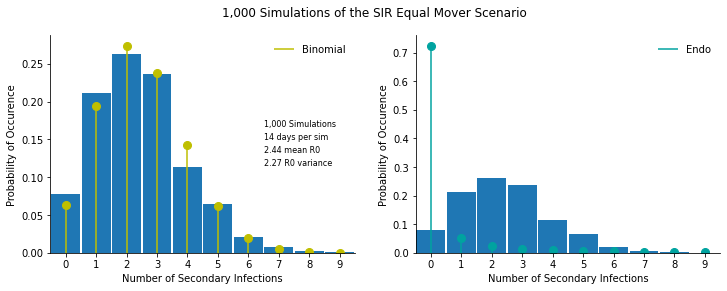

In [99]:
from scipy.stats import binom, nbinom

from rknot.helpers import endo, endoarr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
counts, bins, _ = ax1.hist(
    R0.sum(axis=1), bins=np.arange(R0.sum(axis=1).max() + 2), 
    rwidth=.95, density=True
)

n, p = 14, 2.5/14
binom_f = binom(n, p)
x = np.arange(R0.sum(axis=1).max() + 1)

ax1.plot(x+.5, binom_f.pmf(x), 'bo', ms=8, color='y')
ax1.vlines(x+.5, 0, binom_f.pmf(x), label='Binomial', color='y')

xmax = R0.sum(axis=1).max() + 1
ax1.set_xlim(0, xmax)
ax1.set_xticks([i+.5 for i in range(xmax)])
ax1.set_xticklabels([str(i) for i in range(xmax)])
ax1.set_xlabel('Number of Secondary Infections')
ax1.set_ylabel('Probability of Occurence')

ax1.text(0.7, 0.58, f'{R0.shape[0]:,} Simulations', size=8, transform=ax1.transAxes)
ax1.text(0.7, 0.52, f'{R0.shape[1]:.0f} days per sim', size=8, transform=ax1.transAxes)
ax1.text(0.7, 0.46, f'{R0.sum(axis=1).mean():.2f} mean R0', size=8, transform=ax1.transAxes)
ax1.text(0.7, 0.40, f'{R0.sum(axis=1).var():.2f} R0 variance', size=8, transform=ax1.transAxes)

counts, bins, _ = ax2.hist(
    R0.sum(axis=1), bins=np.arange(R0.sum(axis=1).max() + 2), 
    rwidth=.95, density=True
)
ax2.plot(x+.5, endoarr(x, R0.sum(axis=1).mean()), 'bo', ms=8, color='#00a3a0')
ax2.vlines(x+.5, 0, endoarr(x, R0.sum(axis=1).mean()), label='Endo', color='#00a3a0')
xmax = R0.sum(axis=1).max() + 1

ax2.set_xlim(0, xmax)
ax2.set_xticks([i+.5 for i in range(xmax)])
ax2.set_xticklabels([str(i) for i in range(xmax)])
ax2.set_xlabel('Number of Secondary Infections')
ax2.set_ylabel('Probability of Occurence')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.suptitle(f'{R0.shape[0]:,} Simulations of the SIR Equal Mover Scenario')

plt.show()

In [100]:
R0_density = np.bincount(R0.sum(axis=1)) / R0.shape[0]

msg = 'In the chart on the left, we see the number of secondary '
msg += 'infections created in each iteration of the Equal mover scenario. '
msg += f"In {R0_density[0]:.2%} of all outcomes, the infected subject doesn't infect anyone at all."
md(msg)

In the chart on the left, we see the number of secondary infections created in each iteration of the Equal mover scenario. In 7.80% of all outcomes, the infected subject doesn't infect anyone at all.

We can also see that the distribution of $R_0$ values in the SIR model fits the standard binomial distribution quite well.

This is acutally a shortcoming of the SIR model. In the real world, viral transmission has been shown to function as a negative binomial distribution, where both 0 and much larger outcomes tend to occur far more often.

So with a negative binomial, we would expect that a large proportion of infected subjects will not infect anyone at all and a small number of infected subjects will infect a large number of people.

[Endo et al](https://wellcomeopenresearch.org/articles/5-67#ref-12) provides an estimate of the scaling factor for sars-cov-2 and suggests that *>70% of all primary infections result in 0 secdonary infections*. 

We can see the distribution of the Equal scenario versus the Endo distribution in the plot on the right above. Clearly, there is a poor fit. So, if we are to more accurately reflect the spread of sars-cov-2, we must attempt to replicate the Endo distribution of secondary cases in our environments.

#### Impact of Density ####

There are only two ways (presently) that **RKnot** can increase the contact rate in an environment.

1. Increased density
2. Events

*In the future, contact rate can also be increased by allowing for more ticks per day.*

The impact of population density on viral spread in the real word is more nuanced than one might expect. With respect to sars-cov-2, for example, [studies](https://www.medrxiv.org/content/10.1101/2020.08.21.20179416v2) have found anywhere from zero to weak to strong correlations. Certainly at a country level population density doesn't [appear to have much correlation to covid-19 case counts](https://ourworldindata.org/grapher/covid-19-death-rate-vs-population-density).

Still, all else equal, in so far as population density leads to more contacts we would expect it to lead to greater spread. 

In **RKnot**, population density has exactly that effect. 

In [101]:
file = 'tests/data/transmit'
testdens = 5
db = shelve.open(file, writeback=True)

densdct = db[f'SIR equal 10000n dens{testdens}']['2020-11-15']
db.close()
contacts = densdct['contacts']
R0 = densdct['R0']

In [102]:
meanstr = round(contacts.mean(), 4)
varstr = round(contacts.var(), 4)

msg = f'With a density of {testdens}, the resulting mean contact rate is {meanstr} '
msg += f'with a variance of {varstr}. '

md(msg)

With a density of 5, the resulting mean contact rate is 4.9436 with a variance of 4.9607. 

If we plot the distribution of contacts in a histogram, we see that the peaks have shifted such that far fewer days result in 0 contacts (compared to density 1 above).

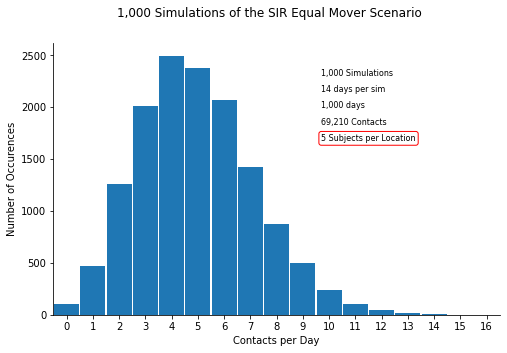

In [103]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,5))
counts, bins, _ = ax1.hist(contacts.ravel(), bins=np.arange(contacts.max() + 2), rwidth=.95)

xmax = contacts.max() + 1
ax1.set_xlim(0, xmax)
ax1.set_xticks([i+.5 for i in range(xmax)])
ax1.set_xticklabels([str(i) for i in range(xmax)])
ax1.set_xlabel('Contacts per Day')
ax1.set_ylabel('Number of Occurences')

ax1.text(0.6, 0.88, f'{contacts.shape[0]:,} Simulations', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.82, f'{contacts.shape[1]} days per sim', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.76, f'{contacts.shape[0]:,} days', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.70, f'{contacts.sum():,} Contacts', size=8, transform=ax1.transAxes)

props = dict(boxstyle='round', facecolor='w', edgecolor='r', ls='-', alpha=1)
ax1.text(0.6, 0.64, f'{testdens} Subjects per Location', size=8, transform=ax1.transAxes, bbox=props)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.suptitle(f'{contacts.shape[0]:,} Simulations of the SIR Equal Mover Scenario')

plt.show()

And we see that the distribution doesn't even sniff Gamma:

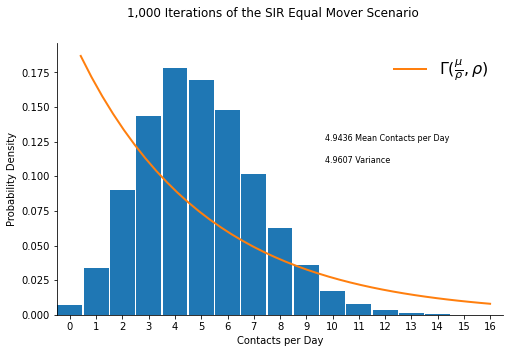

In [104]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,5))

counts, bins, _ = ax1.hist(contacts.ravel(), bins=np.arange(contacts.max() + 2), rwidth=.95, density=True)

a = contacts.mean() / contacts.var()
scale = contacts.var()
rv = gamma(a, scale=scale)
x = np.linspace(0,contacts.max(),40)
ax1.plot(x+0.5, rv.pdf(x), lw=2, label=r'$\Gamma(\frac{\mu}{\rho}, \rho)$')

ax1.set_xlim(0, xmax)
ax1.set_xticks([i+.5 for i in range(xmax)])
ax1.set_xticklabels([str(i) for i in range(xmax)])
ax1.set_xlabel('Contacts per Day')
ax1.set_ylabel('Probability Density')
ax1.text(0.6, 0.64, f'{meanstr:,} Mean Contacts per Day', size=8, transform=ax1.transAxes)
ax1.text(0.6, 0.56, f'{varstr:,} Variance', size=8, transform=ax1.transAxes)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.legend(loc='best', frameon=False, prop={'size': 16})

plt.suptitle(f'{contacts.shape[0]:,} Iterations of the SIR Equal Mover Scenario')
plt.show()

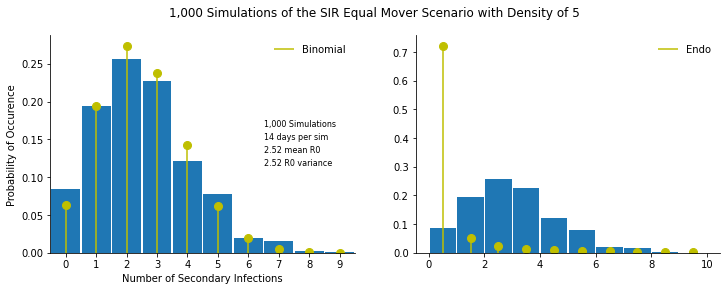

In [105]:
from scipy.stats import binom, nbinom

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
counts, bins, _ = ax1.hist(
    R0.sum(axis=1), bins=np.arange(R0.sum(axis=1).max() + 2), 
    rwidth=.95, density=True
)

n, p = 14, 2.5/14
binom_f = binom(n, p)
x = np.arange(R0.sum(axis=1).max() + 1)

ax1.plot(x+.5, binom_f.pmf(x), 'bo', ms=8, color='y')
ax1.vlines(x+.5, 0, binom_f.pmf(x), label='Binomial', color='y')

xmax = R0.sum(axis=1).max() + 1
ax1.set_xlim(0, xmax)
ax1.set_xticks([i+.5 for i in range(xmax)])
ax1.set_xticklabels([str(i) for i in range(xmax)])
ax1.set_xlabel('Number of Secondary Infections')
ax1.set_ylabel('Probability of Occurence')

ax1.text(0.7, 0.58, f'{R0.shape[0]:,} Simulations', size=8, transform=ax1.transAxes)
ax1.text(0.7, 0.52, f'{R0.shape[1]:.0f} days per sim', size=8, transform=ax1.transAxes)
ax1.text(0.7, 0.46, f'{R0.sum(axis=1).mean():.2f} mean R0', size=8, transform=ax1.transAxes)
ax1.text(0.7, 0.40, f'{R0.sum(axis=1).var():.2f} R0 variance', size=8, transform=ax1.transAxes)

counts, bins, _ = ax2.hist(
    R0.sum(axis=1), bins=np.arange(R0.sum(axis=1).max() + 2), 
    rwidth=.95, density=True
)
ax2.plot(x+.5, endoarr(x, R0.sum(axis=1).mean()), 'bo', ms=8, color='y')
ax2.vlines(x+.5, 0, endoarr(x, R0.sum(axis=1).mean()), label='Endo', color='y')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.suptitle(f'{contacts.shape[0]:,} Simulations of the SIR Equal Mover Scenario with Density of {testdens}')

plt.show()

#### SIR: Measuring Contact Rates ####

So, with a framework for optimizing contact rates, we must now figure out how to measure contact rates and R0 in our simulations.

[We have seen mathematically](#Contact-Rates) that a density of 1 dot per location should result in a mean contact rate of ~1 per day.

Below, we will investigate if that is the case.

We will assume:

+ population of 10,000
+ simulation length of 14 days (equal to the infection duration)
+ density of 1
+ $R_0$ of 2.5

In [4]:
from rknot import Sim

group = dict(
    name='all',
    n=10000,
    n_inf=1,
    ifr=0,
    mover='equal',
)

params = dict(
    density=1,
    R0=2.5,
    infdur=14,
    days=14,
)

When running the sim, we set `dotlog=True`. The `dotlog` is a 3d record of the dot matrix at each tick in the simulation.

*`dotlog` defaults to `False` as it can impact performance for large populations and longer simulations.*

In [6]:
sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [7]:
args = (params['days'], sim.dotlog.shape[1], sim.dotlog.shape[2])
msg = 'Upon completion of the sim, an attribute `dotlog` has been added. '
msg += 'We can see it has shape ({}, {}, {}), '.format(*args) 
msg += 'corresponding to 14 ticks, {:,} dots, '.format(sim.dotlog.shape[1]) 
msg += 'and the {} attributes in the dot matrix.'.format(sim.dotlog.shape[2])

md(msg)

Upon completion of the sim, an attribute `dotlog` has been added. We can see it has shape (14, 10000, 23), corresponding to 14 ticks, 10,000 dots, and the 23 attributes in the dot matrix.

The initial infected dot is chosen at random, so we cannot isolate and track its movements ahead of time. But we *can* isolate it in the first first frame of the `dotlog` and review its entire history in the sim.

We show the first four ticks below.

In [8]:
import numpy as np
from rknot.dots.matrix import ML, MLNB

i_inf = np.argwhere(sim.dotlog[0][:, ML['is_inf']] == 1).ravel()[0]
sim.dotlog[:, i_inf][:4]

array([[5060,    0,    1,    0,    0,    1,    1, 8767,   88,   68, 6889,
          69,   90,    0,    0,   -1,    0,  100,    0,    0,   -1,   15,
         381],
       [5060,    0,    1,    0,    0,    1,    1, 6911,   70,   12, 6889,
          69,   90,    0,    0,   -1,    0,  100,    0,    0,   -1,   15,
         381],
       [5060,    0,    1,    0,    0,    1,    1, 9498,   95,   99, 6889,
          69,   90,    0,    0,   -1,    0,  100,    0,    0,   -1,   15,
         381],
       [5060,    0,    1,    0,    0,    1,    1, 1855,   19,   56, 6889,
          69,   90,    0,    0,   -1,    0,  100,    0,    0,   -1,   15,
         381]])

We can then determine which locations the dot visited at each tick.

In [9]:
locs_visited = sim.dotlog[:, i_inf, ML['loc_id']].ravel()
locs_visited

array([8767, 6911, 9498, 1855, 6004, 1209, 6538, 9566, 9906, 5004, 7797,
        680, 9648, 5393])

In [10]:
db['locs_visited1'] = locs_visited

Next, find how many total dots were at the same location at the same time as the initial infected.

In [11]:
dots_at_loc = sim.dotlog[:,:,ML['loc_id']] == locs_visited[:, None]
dots_at_loc.sum(axis=1)

array([3, 2, 4, 3, 1, 2, 1, 2, 4, 1, 1, 2, 2, 1])

In [12]:
db['dots_at_loc1'] = dots_at_loc

In [13]:
msg = 'The array above tells us there we {:,} dots '.format(dots_at_loc.sum(axis=1)[0])
msg += 'at location id {} on the first tick, '.format(locs_visited[0])
msg += '{} dot{} at '.format(dots_at_loc.sum(axis=1)[1], 's' if dots_at_loc.sum(axis=1)[1] > 1 else '')
msg += 'location id {} on the second tick, etc.'.format(locs_visited[1])

md(msg)

The array above tells us there we 3 dots at location id 8767 on the first tick, 2 dots at location id 6911 on the second tick, etc.

In [14]:
assert (sim.dotlog[0, :, ML['loc_id']] == db['locs_visited1'][0]).sum() == dots_at_loc.sum(axis=1)[0]
assert (sim.dotlog[1, :, ML['loc_id']] == db['locs_visited1'][1]).sum() == dots_at_loc.sum(axis=1)[1]

Next, we subtract 1 from `dots_at_loc` since a contact constitutes two or more dots. Then find the mean and variance of the infected dot's daily contacts.

In [15]:
contacts = dots_at_loc.sum(axis=1) - 1
mean = contacts.mean()
var = contacts.var()

In [16]:
if UPDATEDB:
    db['mean, var 1'] = (mean, var, contacts)
mean, var, contacts = db['mean, var 1']

In [17]:
print (round(mean, 2), round(var, 2))

1.07 1.07


On average, the contacts of the infected dot during the infection period are as expected.

From the contact distribution below, we can see that the majority of days, an infected dot had 0 or 1 contact.

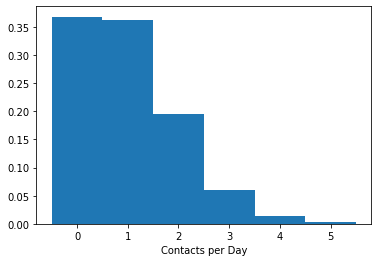

In [90]:
counts, bins, _ = plt.hist(contacts, bins=np.arange(contacts.max() + 2) - 0.5, density=True)
plt.xticks(range(contacts.max() + 1))
plt.yticks()
plt.xlabel('Contacts per Day')
plt.show()

For a larger sample, we can repeat the above process for every dot in the simulation. The `find_all_contacts` method loops through every dot in the dotlog and finds the number of contacts for each dot.

In [91]:
from rknot.dots.matrix import MLNB

all_contacts = find_all_contacts(sim.dotlog[:14], MLNB)
mean = all_contacts.mean()
var = all_contacts.var()

In [92]:
if UPDATEDB:
    db['mean, var 3'] = (mean, var, all_contacts)
mean, var, all_contacts = db['mean, var 3']

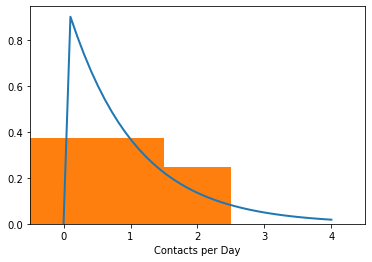

In [95]:
from scipy.stats import gamma

a = mean/var
scale = var
fig, ax = plt.subplots(1, 1)
rv = gamma(a, scale=scale)
x = np.linspace(0,4,40)
ax.plot(x+0.5, rv.pdf(x), lw=2, label='frozen pdf')

counts, bins, _ = ax.hist(contacts, bins=np.arange(contacts.max() + 2), density=True)

xmax = 5
ax.set_xlim(0, xmax)
ax.set_xticks([i+.5 for i in range(xmax)])
ax.set_xticklabels([str(i) for i in range(xmax)])

plt.xlabel('Contacts per Day')
plt.show()

##### We find that all the dots in the sim had a mean contact rate near 1 (as expected) and variance near 1.

Yet another approach is to iterate over a number of different sims and look for the mean and variance of contacts for the infected dot across those sims. 

*Sim allows the server and worker processes to be recycled (by passing `server` and `workers` attributes. This results in faster runtime as the Numba functions need only be loaded once during the first iteration for each server/worker*

In [45]:
from tqdm.auto import trange

days = 14
params = {'density':1, 'R0': 2.5, 'infdur': 14, 'days': days}

n = 200
contacts = np.zeros(days*n, dtype=np.int32)
for i in trange(n):
    if i == 0:
        sim = Sim(groups=group, **params)
    else:
        sim = Sim(groups=group, server=sim.server, workers=sim.workers, **params)
    
    if i == n-1:
        sim.run(dotlog=True, pbar_on=False, kill=True)
    else:
        sim.run(dotlog=True, pbar_on=False, kill=False)
        
    inf_contacts = contacts_of_init_inf(sim.dotlog)
    contacts[i*days:i*days + days] = inf_contacts

mean, var = contacts.mean(), contacts.var()

In [7]:
if UPDATEDB:
    db['mean, var 4'] = (mean, var, contacts)
mean, var, contacts = db['mean, var 4']

Above we see that the infected dot averaged close to 1 contact per day with a variance of ~1 contact per day.

In [28]:
mean

0.9946428571428572

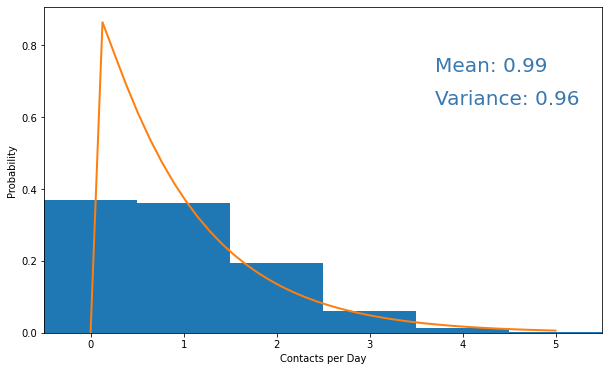

In [30]:
from scipy.stats import gamma

a = mean/var
scale = var
rv = gamma(a, scale=scale)
x = np.linspace(0, contacts.max(), 40)

fig, ax = plt.subplots(1, 1, figsize=(10,6))

counts, bins, _ = ax.hist(contacts, bins=np.arange(contacts.max() + 2), density=True)
ax.plot(x+0.5, rv.pdf(x), lw=2, label='frozen pdf')

xmax = contacts.max() + 1
ax.set_xlim(0, xmax)
ax.set_xticks([i+0.5 for i in range(xmax)])
ax.set_xticklabels([str(i) for i in range(xmax)])

ax.text(.7, .8, f'Mean: {round(mean, 2)}', transform=ax.transAxes, c='#3977af', size=20)
ax.text(.7, .7, f'Variance: {round(var, 2)}', transform=ax.transAxes, c='#3977af', size=20)

plt.ylabel('Probability')
plt.xlabel('Contacts per Day')
plt.savefig('imgs/contact_pdf_equal_mover.png', dpi=100)

#### SIR: Confirming $R_0$ ####

We can similarly use the dotlog to confirm that the simulation results in the correct level of $R_0$, whether passed explicitly or implied through other parameters.

We can measure the *expected* $R_0$ of an infected dot, in any environment, by determining its number of contacts and then multiplying those contacts by the tranmission risk at the time of the contacts. This results in the expected number of transmissions per day, which is then summed.

In [31]:
params = dict(
    density=1,
    R0=2.5,
    infdur=14,
    days=15,
)
group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='equal',
)
sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [32]:
contacts = find_all_contacts(sim.dotlog[:sim.tmrs.shape[0]], MLNB)
contacts_by_dot = contacts.reshape(-1, sim.tmrs.shape[0])
eR0_by_dot = sim.tmrs * contacts_by_dot

In [33]:
np.sum(eR0_by_dot, axis=1).mean()

2.566928571428568

So based on the actual contacts had by each dot in the environment, we would expect any particular dot to create ~2.5 secondary infections, equivalent to $R_0$ of 2.5.

With that in mind, we can investigate the true number of secondary infections by using the `sterile` flag. When `sterile=True`, the sim determines which subjects should be infected for each contact via `_infect_select`, but does *not* call the `_infect` method afterwards.

So no new dots are ever actually infected, but we can still track the number of dots that were *selected* for infection via `sim.log[n_sec]`.

Thus, if `n_inf=1`, `sim.log[n_sec]` gives us the idealized outcome of an infected subject in an entirely sesceptible popualtion.

The sim terminates once the single infected dot recovers.

First, we can use `find_all_contacts` to estimate the mean number of secondary infections we would expect across multiple simulations.

In [169]:
from rknot.helpers import find_n_sec

def looper(
    n, density, days, groups, sterile=True, 
    R0=None, infdur=None, tmr=None, attrs=True,
    events=None,
):
    if tmr is not None:
        infdur = tmr.shape[0]
        params = {'days': days, 'inf_curve': tmr}
    else:
        params = {'R0': 2.5, 'infdur': infdur, 'days': days}
    
    params['density'] = density
    params['sterile'] = sterile
    params['get_attrs'] = attrs
    
    if events is not None:
        params['events'] = events
    
    contacts = np.zeros(infdur*n, dtype=np.int32)
    w_nsecs = np.zeros(n, dtype=np.int32)
    nsec_cs = np.zeros(n, dtype=np.int32)
    nsecs = np.zeros(infdur*n, dtype=np.int32)
    for i in trange(n):
        if i == 0:
            sim = Sim(groups=groups, **params)
        else:
            sim = Sim(groups=groups, server=sim.server, workers=sim.workers, **params)
        if i == n-1:
            sim.run(dotlog=True, pbar_on=False, kill=True)
        else:
            sim.run(dotlog=True, pbar_on=False, kill=False)
        
        tmrs = tmr if tmr is not None else sim.tmrs
            
        w_nsecs[i], nsec_cs[i] = find_n_sec(sim.dotlog[:infdur+1], tmrs)
        inf_contacts = contacts_of_init_inf(sim.dotlog[:infdur])
        contacts[i*infdur:i*infdur + infdur] = inf_contacts
        nsecs[i*infdur:i*infdur + infdur] = sim.log['n_sec'][1:-1]
    
    return contacts, nsecs


In [170]:
n = 250
density = 1
infdur = 14
days = infdur + 1
R0 = 2.5
w_nsecs, nsec_cs, contacts, nsecs = looper(n, density, days, group, R0=R0, infdur=infdur)

mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = w_nsecs.mean(), w_nsecs.var()
eR0 = np.mean(contacts.reshape(-1,infdur)*sim.tmrs, axis=0).sum()
R0 = nsecs.reshape(-1, infdur).sum(axis=1).mean()

AttributeError: 'ActorHandle' object has no attribute 'transmit2'

In [41]:
assert nsec_cs.mean() == contacts.reshape(-1, infdur).sum(axis=1).mean()

In [42]:
print (mean_ktr, var_ktr)
print (mean_nsec, mean_ktr)
print (eR0, R0)

1.008 0.9896502857142858
0.0 1.008
2.4947999999999944 2.56


In [47]:
if False:
    db['nsecs mean, var 1'] = (n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0)
n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0 = db['nsecs mean, var 1']

In [53]:
msg = 'We see here that, across {} sims, the $R_0$ is '.format(n)
msg += 'within {:.0%} of expected R0 based on contacts. '.format(round(R0 / eR0, 2) - 1)

md(msg)

We see here that, across 250 sims, the $R_0$ is within 3% of expected R0 based on contacts. 

#### SIR: Impact of Changes in Mover Function ###

With the veracity of the SIR model and the assessment process confirmed, we can check the impact of changes to various attributes of the sim, including the `mover` function.

In [54]:
group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='local',
)

infdur = 14
days = infdur + 1
params = {'density': 1, 'R0': 2.5, 'infdur': infdur, 'days': days}

n = 250
density = 1
infdur = 14
days = infdur + 1
R0 = 2.5
w_nsecs, nsec_cs, contacts, nsecs = looper(n, density, days, group, R0=R0, infdur=infdur)

mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = w_nsecs.mean(), w_nsecs.var()
eR0 = np.mean(contacts.reshape(-1,infdur)*sim.tmrs, axis=0).sum()
R0 = nsecs.reshape(-1, infdur).sum(axis=1).mean()

In [55]:
mean_nseccs = nsec_cs.mean()
c = contacts.reshape(-1, infdur).sum(axis=1).mean()
assert mean_nseccs == c, f'{mean_nseccs} v {c}'

In [56]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)
print (eR0, R0)

0.9794285714285714 1.0424339591836735
0.0 0.0
2.4240857142857095 2.528


In [57]:
if False:
    db['nsecs mean, var local'] = (n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0)
n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0 = db['nsecs mean, var local']

Despite the signficant change in movement pattern, [which we know results in a very different infection curve](sir.ipynb#2.-Local), the $R_0$ does not decline significantly. In fact, it increases.

#### Customization ####

We can use this testing approach to build custom simulation environments.

For example, in this [paper](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf), the authors fit a transmission risk profile of sars-cov-2 to several properties of the environment including:
+ mean $R_0$ of 1.8
+ 4 contacts per day
+ 40 variance of contacts

RKnot's event structure can help to simulate the required level of variance.
We can import the tmr curve from `rknot.dots.fhutch`.

As with above, we will first investigate the expected number of contacts and secondary infections using `find_all_contacts` under the usual density of 1.

In [84]:
from rknot.dots.fhutch import tmr

group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='equal',
)

n = 250
density = 1
days = tmr.shape[0] + 1
attrs = False
infdur = tmr.shape[0]
w_nsecs, nsec_cs, contacts, nsecs = looper(n, density, days, group, tmr=tmr, attrs=attrs)

In [85]:
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = w_nsecs.mean(), w_nsecs.var()
eR0 = np.mean(contacts.reshape(-1,infdur)*tmr, axis=0).sum()
R0 = nsecs.reshape(-1, infdur).sum(axis=1).mean()

print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)
print (eR0, R0)

The expected $R_0$ using density of 1 dot per subject is much lower than the 1.8 target.

We have two options: 1) Use events to significantly increase the number of contacts (and the variance) or, 2) increase the density.

We'll start with option 1.

We can replicate the required contact frequency and variance quite simply using events. 

We can maintain the density of 1 subject per location and implement a series of 100 separate events, each with a capacity of 18 subjects, and each recur daily beginning on tick 1.

*Here, we will switch to our `baseus` simulation environment, as its size is more conducive to a higher contact variance.*

In [157]:
from rknot.events import Event
from rknot.sims import baseus
from rknot.helpers import modulereload
import math

from rknot.nb import funcs as nbf

modulereload(baseus)

groups = baseus.groups
groups[2]['n_inf'] = 0

density = 1
square = math.ceil(math.sqrt(sum(g['n'] for g in groups)/density))

n = 50
rng = np.arange(1, square+1)
coords = nbf.meshgrid(rng, rng)
loc_ids = np.random.choice(np.arange(coords.shape[0]), size=n, replace=False)

events = []
for i in range(n):
    name = 'event_{}'.format(i)
    events.append(
        Event(
            name=name, xy=coords[loc_ids[i]], start_tick=1, 
            groups=[0,1,2,3], capacity=25, recurring=1
        )
    )

We can chart the capacity of the events over time as per below.

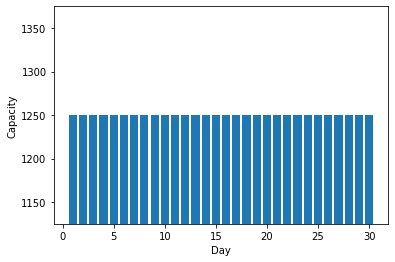

In [158]:
ticks = [i for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]
caps = [e.capacity for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]

from collections import Counter
c = Counter()
for tick, cap in zip(ticks, caps):
    c[tick] += cap

plt.bar(c.keys(), c.values())
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.ylim(min(c.values())*0.9, max(c.values())*1.1)
plt.show()

We can see the event structure proposed has limited variation, but because the density of the simulation is low, this will still lead to significant contact variance.

In [159]:
n = 250
days = tmr.shape[0] + 1
attrs = False
infdur = tmr.shape[0]
w_nsecs, nsec_cs, contacts, nsecs = looper(n, density, days, groups, tmr=tmr, attrs=attrs, events=events)

In [160]:
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = w_nsecs.mean(), w_nsecs.var()
eR0 = np.mean(contacts.reshape(-1,infdur)*tmr, axis=0).sum()
R0 = nsecs.reshape(-1, infdur).sum(axis=1).mean()

print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)
print (eR0, R0)

3.8850666666666664 64.75959032888889
0.0 0.0
1.5588820938407884 1.528


In [161]:
if True:
    db['nsecs mean, var cust2'] = (n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0)
n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0 = db['nsecs mean, var cust2']

The chart below shows the variability of the infected dot's contacts over time.

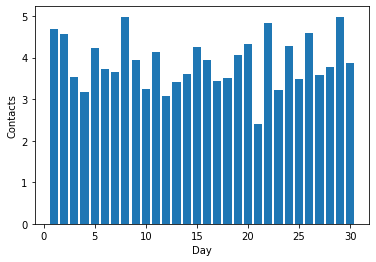

In [162]:
ktr_by_day = contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Contacts')
plt.show()

************

In [69]:
import numpy as np
import matplotlib.pyplot as plt

from rknot import Sim
from rknot.events import Event
from rknot.sims import baseus
from rknot.helpers import modulereload, looper, contacts_of_init_inf
from rknot.dots.matrix import MLNB
from rknot.nb import funcs as nbf
from rknot.dots.fhutch import tmr, tmr75, gamma
modulereload(baseus)

import math

groups = baseus.groups
groups[2]['n_inf'] = 0

density = 1
days = tmr.shape[0] + 1

square = math.ceil(math.sqrt(sum(g['n'] for g in groups)/density))

n = 2340
events = []

rng = np.arange(1, square+1)
coords = nbf.meshgrid(rng, rng)
loc_ids = np.random.choice(np.arange(coords.shape[0]), size=n, replace=False)

event_groups = [
    {   
        'name': '3n',
        'n': 900,
        'groups': [[0,1,2], [1,2], [0,1,2,3]],
        'startargs': (1,2,1),
        'pvals': [0.3, 0.5, 0.2],
        'capacity': 3,
        'recurring': 1,
    }, {   
        'name': '4n',
        'n': 750,
        'groups': [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]],
        'startargs': (1,3,1),
        'pvals': [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05],
        'capacity': 4,
        'recurring': 1,
    }, {   
        'name': '5n',
        'n': 300,
        'groups': [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]],
        'startargs': (1,2,1),
        'pvals': [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05],
        'capacity': 5,
        'recurring': 2,
    }, {   
        'name': '6n',
        'n': 220,
        'groups': [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]],
        'startargs': (1,3,1),
        'pvals': [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05],
        'capacity': 6,
        'recurring': 3,
    }, {   
        'name': '20n',
        'n': 100,
        'groups': [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]],
        'startargs': (1,7,1),
        'pvals': [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05],
        'capacity': 20,
        'recurring': 7,
    },
    {   
        'name': '50n',
        'n': 35,
        'groups': [[0,1,2], [1,2], [0,1], [2,3]],
        'startargs': (1,7,1),
        'pvals': [0.35, 0.25, 0.25, 0.15],
        'capacity': 50,
        'recurring': 14,
    }, {   
        'name': '50n',
        'n': 25,
        'groups': [[0,1,2], [1,2], [0,1], [2,3]],
        'startargs': (7,14,1),
        'pvals': [0.35, 0.25, 0.25, 0.15],
        'capacity': 50,
        'recurring': 14,
    },

        {   
        'name': '100n',
        'n': 5,
        'groups': [[0,1,2], [1,2], [0,1,2,3]],
        'startargs': (1,7,1),
        'pvals': [0.3, 0.5, 0.2],
        'capacity': 50,
        'recurring': 28,
    },
        {   
        'name': '100n',
        'n': 5,
        'groups': [[0,1,2], [1,2], [0,1,2,3]],
        'startargs': (7,28,1),
        'pvals': [0.3, 0.5, 0.2],
        'capacity': 50,
        'recurring': 28,
    },

]

ns = np.array([e['n'] for e in event_groups])
assert ns.sum() == n, f'{ns.sum()} v {n}'

events = []
for i, e in enumerate(event_groups):
    for j in range(e['n']):
        loc_idx = j + e['n']*(i)
        start_tick = np.random.randint(*e['startargs'], dtype=np.int32)
        i_groups = np.random.choice(np.arange(len(e['groups'])), size=1, p=e['pvals'])
        e_groups = e['groups'][i_groups[0]]
        events.append(
            Event(
                name='{}_{}'.format(e['name'], j), xy=coords[loc_ids[loc_idx]], start_tick=start_tick[0],
                groups=e_groups, 
                capacity=e['capacity'], recurring=e['recurring']
            )
        )

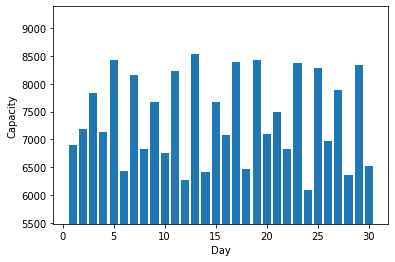

In [70]:
ticks = [i for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]
caps = [e.capacity for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]

from collections import Counter
c = Counter()
for tick, cap in zip(ticks, caps):
    c[tick] += cap

plt.bar(c.keys(), c.values())
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.ylim(min(c.values())*0.9, max(c.values())*1.1)
plt.show()

In [82]:
params = dict(
    groups=baseus.groups, 
    events=events, 
    days=365, 
    get_attrs=False, 
    inf_curve=tmr,
    density=density,
)
sim = Sim(**params)
sim.run(dotlog=True)

In [83]:
contacts = contacts_of_init_inf(sim.dotlog[:tmr.shape[0]])
all_contacts = nbf.find_all_contacts(sim.dotlog[:tmr.shape[0]], MLNB)

mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_ktr_all, var_ktr_all = all_contacts.mean(), all_contacts.var()
eR0 = np.mean(contacts.reshape(-1,tmr.shape[0])*tmr, axis=0).sum()
eR0_all = (all_contacts.reshape(-1, tmr.shape[0])*tmr).sum(axis=1).mean()

In [85]:
print (mean_ktr, var_ktr)
print (mean_ktr_all, var_ktr_all)
print (eR0, eR0_all)

4.566666666666666 101.57888888888893
3.4734533333333335 40.443355274488894
4.432788742910466 2.2529324980234224


In [86]:
from rknot.helpers import pickload, picksave

In [76]:
eventfile = 'rknot/events/eventlists'
# structures = pickload(eventfile)dd

# picksave(eventfile, structures)

In [62]:
n = 10
days = tmr.shape[0] + 1
attrs = False
infdur = tmr.shape[0]
contacts, nsecs, results = looper(n, density, days, groups, tmr=tmr, attrs=attrs, events=events)

In [65]:
mean_ktr, var_ktr = contacts.mean(), contacts.var()
eR0 = np.mean(contacts.reshape(-1,infdur)*tmr, axis=0).sum()
R0 = nsecs.reshape(-1, infdur).sum(axis=1).mean()

print (mean_ktr, var_ktr)
print (eR0, R0)

3.37 49.6531
2.48713615404826 1.6


In [166]:
if True:
    db['results_3'] = (n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0)
n, infdur, contacts, mean_ktr, var_ktr, mean_nsec, var_nsec, eR0, R0 = db['results_3']

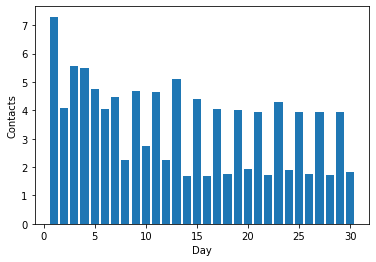

In [161]:
ktr_by_day = all_contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Contacts')
plt.show()

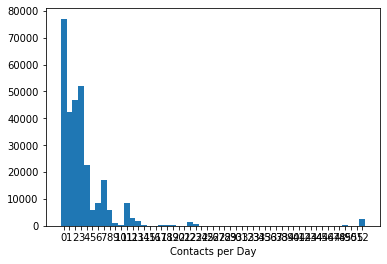

In [163]:
plt.hist(all_contacts, bins=np.arange(contacts.max() + 2) - 0.5)
plt.xticks(range(contacts.max() + 1))
plt.xlabel('Contacts per Day')
plt.show()

In [ ]:
params = dict(
    groups=baseus.groups, 
    events=events, 
    days=365, 
    get_attrs=False, 
    inf_curve=tmr,
    density=density,
)
sim = Sim(**params)
sim.run(dotlog=True)

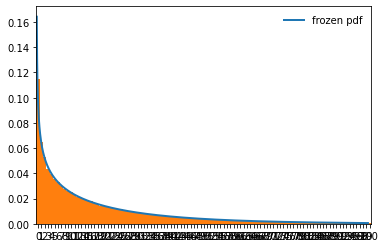

In [230]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
a = 20/30
scale = 30
fig, ax = plt.subplots(1, 1)
rv = gamma(a, scale=scale)
x = np.linspace(0,100,1000)
ax.plot(x, rv.pdf(x), lw=2, label='frozen pdf')

r = gamma.rvs(a, scale=scale, size=100000)
count, bins, ignored = plt.hist(r, bins=np.arange(300), density=True)

xmax = 101
ax.set_xlim(0, xmax)
ax.set_xticks([i+.5 for i in range(xmax)])
ax.set_xticklabels([str(i) for i in range(xmax)])
ax.legend(loc='best', frameon=False)

plt.show()

#### TMR75 ####

In [68]:
import numpy as np
import matplotlib.pyplot as plt

from rknot import Sim
from rknot.events import Event
from rknot.sims import baseus
from rknot.helpers import modulereload, looper, contacts_of_init_inf
from rknot.dots.matrix import MLNB
from rknot.nb import funcs as nbf
from rknot.dots.fhutch import tmr, tmr75, tmr725, gamma
modulereload(baseus)

import math

groups = baseus.groups
groups[2]['n_inf'] = 0

density = 10
days = tmr.shape[0] + 1

square = math.ceil(math.sqrt(sum(g['n'] for g in groups)/density))

n = 512
events = []

rng = np.arange(1, square+1)
coords = nbf.meshgrid(rng, rng)
loc_ids = np.random.choice(np.arange(coords.shape[0]), size=n, replace=False)

event_groups = [
    {   
        'name': '12n',
        'n': 200,
        'groups': [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]],
        'startargs': (1,2,1),
        'pvals': [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05],
        'capacity': 12,
        'recurring': 2,
    }, {   
        'name': '15n',
        'n': 200,
        'groups': [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]],
        'startargs': (1,3,1),
        'pvals': [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05],
        'capacity': 6,
        'recurring': 3,
    }, 
    {   
        'name': '20n',
        'n': 100,
        'groups': [[0,1,2], [1,2], [0,1], [2,3], [0], [1], [2], [3]],
        'startargs': (1,7,1),
        'pvals': [0.20, 0.25, 0.15, 0.05, 0.1, 0.1, 0.1, 0.05],
        'capacity': 20,
        'recurring': 7,
    },
    {   
        'name': '50n',
        'n': 2,
        'groups': [[0,1,2], [1,2], [0,1], [2,3]],
        'startargs': (1,7,1),
        'pvals': [0.35, 0.25, 0.25, 0.15],
        'capacity': 50,
        'recurring': 14,
    }, {   
        'name': '50n',
        'n': 2,
        'groups': [[0,1,2], [1,2], [0,1], [2,3]],
        'startargs': (7,14,1),
        'pvals': [0.35, 0.25, 0.25, 0.15],
        'capacity': 50,
        'recurring': 14,
    },

        {   
        'name': '100n',
        'n': 1,
        'groups': [[0,1,2], [1,2], [0,1,2,3]],
        'startargs': (1,7,1),
        'pvals': [0.3, 0.5, 0.2],
        'capacity': 50,
        'recurring': 28,
    },
        {   
        'name': '100n',
        'n': 1,
        'groups': [[0,1,2], [1,2], [0,1,2,3]],
        'startargs': (7,28,1),
        'pvals': [0.3, 0.5, 0.2],
        'capacity': 50,
        'recurring': 28,
    },

]

ns = np.array([e['n'] for e in event_groups])
assert ns.sum() == n, f'{ns.sum()} v {n}'

events = []
for i, e in enumerate(event_groups):
    for j in range(e['n']):
        loc_idx = j + e['n']*(i)
        start_tick = np.random.randint(*e['startargs'], dtype=np.int32)
        i_groups = np.random.choice(np.arange(len(e['groups'])), size=1, p=e['pvals'])
        e_groups = e['groups'][i_groups[0]]
        events.append(
            Event(
                name='{}_{}'.format(e['name'], j), xy=coords[loc_ids[loc_idx]], start_tick=start_tick[0],
                groups=e_groups, 
                capacity=e['capacity'], recurring=e['recurring']
            )
        )

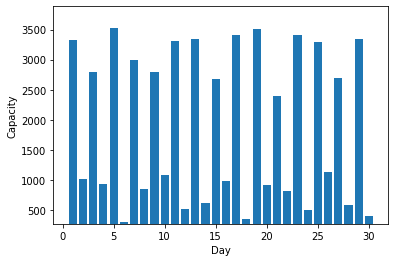

In [69]:
ticks = [i for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]
caps = [e.capacity for e in events for i in range(e.start_tick, tmr.shape[0] + 1, e.recurring)]

from collections import Counter
c = Counter()
for tick, cap in zip(ticks, caps):
    c[tick] += cap

plt.bar(c.keys(), c.values())
plt.xlabel('Day')
plt.ylabel('Capacity')
plt.ylim(min(c.values())*0.9, max(c.values())*1.1)
plt.show()

In [70]:
params = dict(
    groups=baseus.groups, 
    events=events, 
    days=days, 
    get_attrs=False, 
    inf_curve=tmr75,
    density=density,
)
sim = Sim(**params)
sim.run(dotlog=True)

(pid=25552) Initializing setup ... creating boxes and gates ... 
(pid=25552) creating 4 groups ... creating dots ... Complete.
(pid=25552) Setting schedule. 
(pid=25552) Adding recurring events.
(pid=25552) Structing openers, closers, multis, etc.
(pid=25552) Set event ids and find boxes/gates
(pid=25552) Event Schedule Complete.



In [71]:
contacts = contacts_of_init_inf(sim.dotlog[:tmr.shape[0]])
all_contacts = nbf.find_all_contacts(sim.dotlog[:tmr.shape[0]], MLNB)

mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_ktr_all, var_ktr_all = all_contacts.mean(), all_contacts.var()
eR0 = np.mean(contacts.reshape(-1,tmr.shape[0])*tmr75, axis=0).sum()
eR0_all = (all_contacts.reshape(-1, tmr.shape[0])*tmr75).sum(axis=1).mean()

In [72]:
print (mean_ktr, var_ktr)
print (mean_ktr_all, var_ktr_all)
print (eR0, eR0_all)

15.166666666666666 111.40555555555558
11.659306666666666 52.470094719288895
1.6697707452796815 1.7843485579006548


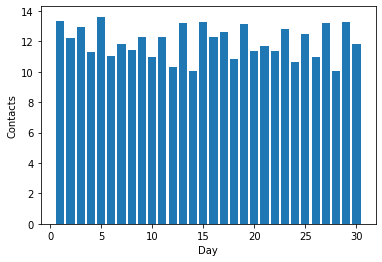

In [62]:
ktr_by_day = all_contacts.reshape(-1,tmr.shape[0]).mean(axis=0)
plt.bar(np.arange(1, tmr.shape[0] + 1), ktr_by_day)
plt.xlabel('Day')
plt.ylabel('Contacts')
plt.show()

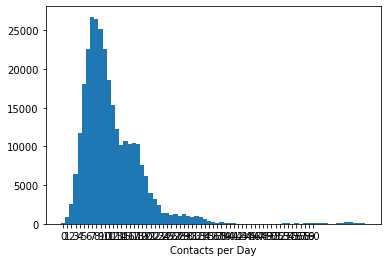

In [166]:
plt.hist(all_contacts, bins=np.arange(all_contacts.max() + 2) - 0.5)
plt.xticks(range(contacts.max() + 1))
plt.xlabel('Contacts per Day')
plt.show()

In [ ]:
%%javascript
 IPython.notebook.save_notebook()

In [93]:
from rknot.helpers import move_to_doc_folder
move_to_doc_folder('sizing.ipynb')